
# Vector Representations
## *Data Science Unit 4 Sprint 1 Assignment 2*

## 0.1 Get `spacy`

##0.2 Restart Runtime

## 0.3 Imports

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_md")

##0.4 Clone the git repo
so we can access the files in the `/data` folder

In [2]:
# !git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git


## 1) Clean the Job Listings from indeed.com that contain the title "Data Scientist" 

The file `job_listings.csv` is in the `data` folder for this module. <br>
Navigate to the `data` folder in the `DS-Unit-4-Sprint-1-NLP` folder icon in the left sidebar. 
Find the path to `job_listings.csv` (all the way at the bottom of the list of files in `data`), by clicking on the "three dots" symbol to the right of its file icon.

In [3]:
data_path = "data\job_listings.csv"
df = pd.read_csv(data_path)

In [4]:
df.shape

(426, 3)

In [5]:
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


### Remove `HTML tags`

The text data in the description column is messy - it's full of html tags! <br>
Use the [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column by removing html tags. <br>
* You will need to read through the `BeautifulSoup` documentation to accomplish this task. <br>
* As with any library, there is lots of documentation, but read only what you need! 
* Don't spend more time than it takes to figure out how to remove html tags! 


In [6]:
def remove_html(text):
    """
    Extract text from html boiler plate code. 
    Converts bytes dtype into str dtype
    
    Note
    ----
    Use the regex editor to help you create regular expressions https://regex101.com/
    
    Parameters
    ----------
    text: string or object 
        contains text data that we want to clean
    
    Returns 
    -------
    text: str 
        cleaned text data ready for vectorization
    """
    
    # create soup object 
    soup = BeautifulSoup(text, 'html.parser')
    
    # extract text from page using beautiful soup
    # eval will strip off whatever datatype or expression that's inside of a string 
    #    see https://docs.python.org/3/library/functions.html#eval for eval docs
    text =  eval(soup.get_text())
    
    # if text is a byte data type, then convert to string 
    if isinstance(text, bytes):
        
        # convert byte data type into str
        text =  text.decode("utf-8")
        
    
    # use regex to clean your text data
    text = re.sub('[^A-Za-z ]', '', text)
   
    
    # case normalize and strip extra white spaces on the far left and right hand side
    text = text.lower().strip()


    return text

In [7]:
df["clean_text"] = df.description.apply(lambda text: remove_html(text))
# would this work? df["clean_text"] = df.description.apply(remove_html)

In [8]:
df.clean_text

0      job requirementsconceptual understanding in ma...
1      job descriptionas a data scientist  you will h...
2      as a data scientist you will be working on con...
3      a monthcontractunder the general supervision o...
4      location usa  multiple locations years of anal...
                             ...                        
421    about uswant to be part of a fantastic and fun...
422    internshipat uber we ignite opportunity by set...
423    a yeara million people a year die in car colli...
424    senior data scientistjob descriptionabout usam...
425    cerner intelligence is a new innovative organi...
Name: clean_text, Length: 426, dtype: object

## 2) Use Spacy to tokenize the listings 
Remove stop words, punctuation and spaces, and whatever else you want to remove

In [9]:
## YOUR CODE HERE
def tokenizer(text):
    """
    Uses spaCy language model to tokenize text. 
    Token filters are used to exclude low quality tokens.
    
    Note
    ----
    Remember to check out the spacy docs to see which token flags are available for you to use
    https://spacy.io/api/token
    
    Input
    ----------
    text: string
        raw text document that needs to be tokenized
        
    Returns
    -------
    tokens: list of strings
    """

    doc = nlp(text)

    # Create a list of tokens using nlp and the sample string "text"
    tokens = []

    # iterate through the tokens in the doc
    for token in doc:

        # create a couple of filters for low quality tokens 
        if (token.is_stop != True) and (token.is_punct != True):
            # save case normalized lemmas to token list 
            tokens.append(token.lemma_)
            
    return tokens

### Apply our tokenizer function via `pandas.apply()`

In [10]:
df["lemmas"] = df.clean_text.apply(tokenizer)

In [11]:
df["lemmas"]

0      [job, requirementsconceptual, understanding, m...
1      [job, descriptiona, data, scientist,  , help, ...
2      [data, scientist, work, consult, business, res...
3      [monthcontractunder, general, supervision, pro...
4      [location, usa,  , multiple, location, year, a...
                             ...                        
421    [uswant, fantastic, fun, startup, s, revolutio...
422    [internshipat, uber, ignite, opportunity, set,...
423    [yeara, million, people, year, die, car, colli...
424    [senior, datum, scientistjob, descriptionabout...
425    [cerner, intelligence, new, innovative, organi...
Name: lemmas, Length: 426, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

- Instantiate a `CountVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `CountVectorizer`
- Use `CountVectorizer` to create a *document-term matrix* 
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `CountVectorizer` object
- Consider using `CountVectorizer` parameters like `stop_words` and `max_df`, `min_df` to trim your results
    
Once you've created your `dtm` dataframe, you might notice that some (or many) of your features result from data that still needs more cleaning. Use this as an opportunity to iteratively improve your `tokenizer` function. 

In [12]:
vect = CountVectorizer(stop_words='english',
                       tokenizer=tokenizer,
                       ngram_range=(1,3),
                       min_df=3,
                       max_df=0.25
                    )
dtm_tf = vect.fit_transform(df.clean_text) # I didnt guess it was clean_text
# Here, tf stands for "term frequency, i.e. counts for each term"
dtm_tf = pd.DataFrame(data=dtm_tf.toarray(), columns=vect.get_feature_names_out())
print(dtm_tf.shape)
dtm_tf.head()

(426, 14909)


,,,,yearsrequirement,international,pm,year,year,year experience,ability,...,york officesdepending,york officesdepending area,youa,youabout,youabout opportunity,youabout opportunity responsible,youour,youthe,youwe,youyou
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
dtm_tf.head(10)

,,,,yearsrequirement,international,pm,year,year,year experience,ability,...,york officesdepending,york officesdepending area,youa,youabout,youabout opportunity,youabout opportunity responsible,youour,youthe,youwe,youyou
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts in a barplot

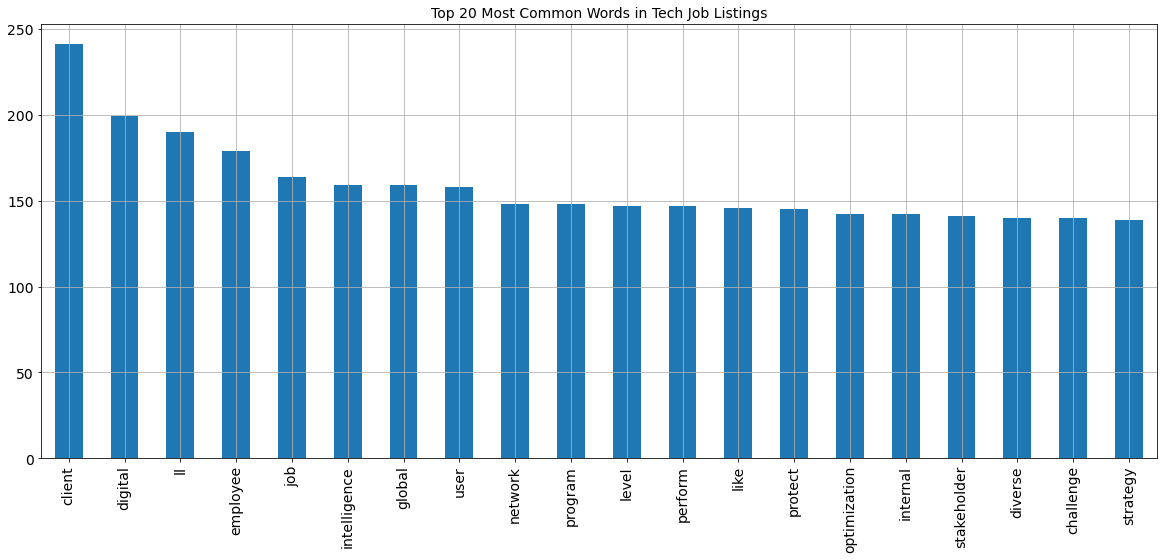

In [14]:
top_n = 20
# sum the term counts in each column of the dtm_tf data frame and then sort in descending order
sorted_terms = dtm_tf.sum().sort_values(ascending=False)

plt.title("Top {} Most Common Words in Tech Job Listings".format(top_n), fontsize=14)
sorted_terms[:top_n].plot(kind="bar",figsize=(20,8),grid=True,fontsize=14);

## 5) Use Scikit-Learn's `TfidfVectorizer` to get a TF-IDF feature matrix

- Instantiate a `TfidfVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `TfidfVectorizer`
- Use `TfidfVectorizer` to create a *tf-idf feature matrix* 
- Copy your *tf-idf feature matrix* into a `pandas` dataframe, getting the column names from the `TfidfVectorizer` object


In [15]:
tfidf = TfidfVectorizer(stop_words='english',
                       tokenizer=tokenizer,
                       ngram_range=(1,3),
                       min_df=3,
                       max_df=0.25)

# Create a vocabulary and get word counts per document
tfidf = tfidf.fit(df.clean_text)
dtm_tfidf = tfidf.transform(df.clean_text).toarray()

C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [16]:
dtm_tfidf_df = pd.DataFrame(data=dtm_tfidf, columns=vect.get_feature_names_out())
print(dtm_tfidf_df.shape)
dtm_tfidf_df.head()

(426, 14909)


,,,,yearsrequirement,international,pm,year,year,year experience,ability,...,york officesdepending,york officesdepending area,youa,youabout,youabout opportunity,youabout opportunity responsible,youour,youthe,youwe,youyou
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.070417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
dtm_tfidf 

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05754407, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

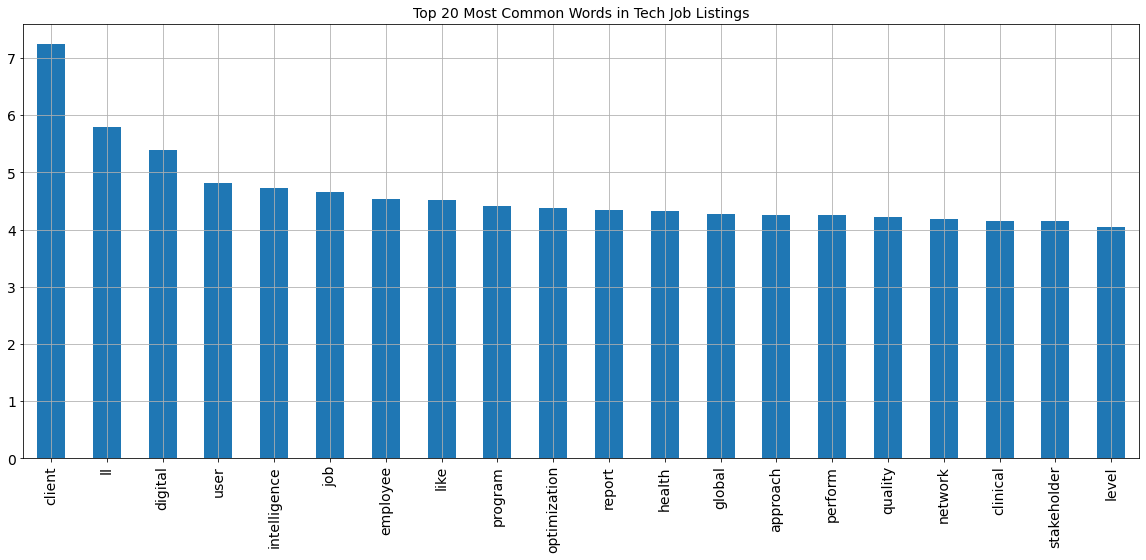

In [20]:
top_n = 20
# sum the term counts in each column of the dtm_tf data frame and then sort in descending order
sorted_terms = dtm_tfidf_df.sum().sort_values(ascending=False)

plt.title("Top {} Most Common Words in Tech Job Listings".format(top_n), fontsize=14)
sorted_terms[:top_n].plot(kind="bar",figsize=(20,8),grid=True,fontsize=14);

Stretch: see if you can make a visualization of this TF-IDF Document-Term  matrix, as you did in Part 3 for the CountVectorizer Document-Term matrix, i.e. using a barplot.

## 6) Create a `NearestNeighbor` Model for the Data Science job listings
Write a some text that describes your ideal Data Science job, and query the model to identify jobs with similar descriptions!

In [22]:
ideal_ds_job_query = [" We are looking for a Data Scientist to analyze large amounts of information to find patterns that will help improve our company. We will rely on you to build data  products to extract valuable business insights.In this role, you should be highly analytical with a knack for analysis, math and statistics. Critical thinking and problem-solving skills are essential for interpreting data. We also want to see a passion for machine-learning and research. Your goal will be to help our company analyze trends to make better decisions.Responsibilities Identify valuable data sources and automate collection processes Undertake preprocessing of structured and unstructured data Analyze large amounts of information to discover trends and patterns Build predictive models and machine-learning algorithms Combine models through ensemble modeling Present information using data visualization techniques Propose solutions and strategies to business challenges Collaborate with engineering and product development teams Requirements and skill Proven experience as a Data Scientist or Data Analyst Experience in data mining Understanding of machine-learning and operations research Knowledge of R, SQL and Python; familiarity with Scala, Java or C++ is an assetExperience using business intelligence tools (e.g. Tableau) and data frameworks (e.g. Hadoop)Analytical mind and business acumenStrong math skills (e.g. statistics, algebra)Problem-solving aptitude Excellent communication and presentation skillsBSc/BA in Computer Science, Engineering or relevant field; graduate degree in Data Science or other quantitative field is preferred"]

In [23]:
# vectorize your ideal job description using your fitted tfidf vectorizer 
ideal_job_vector = tfidf.transform(ideal_ds_job_query).toarray()
# What comes out of this transform is a sparse matrix and what we want is a dense matrix
# so the .toarray method will turn that into a numpy array which is what we want to be 
# able to query in our database.


In [31]:
len(ideal_job_vector) # >> 1
type(ideal_job_vector) # >> numpy.ndarray
len(ideal_job_vector[0]) # >> 14909 << The first element
ideal_job_vector.shape # >> (1, 14909) << Its a 1 dimensional array
sum(ideal_job_vector[0]) # >> 10.023683884017913 << Theyre small #s I guess.
# ideal_job_vector

10.023683884017913

In [32]:

# fit NearestNeighbors model to the Indeed reviews document-term matrix that you created
top_n_neigh = 3
nn = NearestNeighbors(n_neighbors=top_n_neigh)
nn.fit(dtm_tfidf)

# get top_n_neigh distances and review indices for reviews that are closest to your ideal job
n_dist, n_ind = nn.kneighbors(ideal_job_vector)


In [34]:
count = 0
for most_sim_job_index in n_ind[:][0]:
    most_sim_job = df.clean_text.iloc[most_sim_job_index]
    count+=1
    print('\n',count,". ",most_sim_job)


 1 .  as a data scientist you will be working on consulting side of our business you will be responsible for analyzing large complex datasets and identify meaningful patterns that lead to actionable recommendations you will be performing thorough testing and validation of models and support various aspects of the business with data analyticsability to do statistical modeling build predictive models and leverage machine learning algorithmsthis position will combine the typical data scientist math and analytical skills with research advanced business communication and presentation skillsprimary job location is in sacramento but workfromhome option is availablequalificationsbachelors ms or phd in a relevant field computer science engineering statistics physics applied mathexperience in r andor python is preferred

 2 .  at yeti we believe that time spent outdoors matters more than ever and our gear can make that time extraordinary when you work here youll have the opportunity to create e

In [ ]:

# look at a few of the most similar job descriptions to your ideal job
# Did your query find good matches?
# Yes Good Stuff 


## Stretch Goals: do one of more of these that strike your fancy!

 - Repeat Part 6, but this time using spacy's word embeddings to represent documents as vectors. Remember, to form a document vector from spacy word embeddings, you average together the word embedding vectors of all the words in the document, so the document vector will have the same dimensionality as the word embeddings, namely 300 dimensions. Do you notice any difference in the results?
 - Watch Josh Starmer's video [StatQuest: Principal Component Analysis (PCA), Step-by-Step](https://www.youtube.com/watch?v=FgakZw6K1QQ). Or read [Daniela Witten's tweetstorm](https://twitter.com/womeninstat/status/1285610321747611653?lang=en) on Singular Value Decomposition (SVD). Now go back and review the section "Can we visualize word vectors?" from the [lecture video](https://drive.google.com/file/d/1QuwkO2Uj5sONFtqCk0_d2zrks2I6stkN/view?usp=sharing). Write a brief description of your understanding of Principal Components Analysis, and how it was used to visualize word vectors. Do your own experiments to explore relationships of words in two dimensions. Write a summary of what you discovered.

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings?
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. Hint: compose a query that references a number of tech stack items. How are those items distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this; algorithms that depend on Euclidean distance break down with high dimensional data. Do a bit of research to see if you can identify a suitable clustering algorithm.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for.